In [119]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as T

from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict

In [120]:
# Get device info
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# define params
BATCH_SIZE = 256
MOMENTUM = 0.9
LR = 0.01
WEIGHT_DECAY = 0.0005
EPOCHS = 20

In [121]:
# define dataset transformers
transformers = T.Compose([
    T.ToTensor()
])

In [122]:
# define datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data/CIFAR-10/', train=True, transform=transformers, download=True)
val_dataset = torchvision.datasets.CIFAR10(root='./data/CIFAR-10/', train=False, transform=transformers, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [123]:
# define dataloader
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [124]:
# define label_txt
LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


torch.Size([256, 3, 32, 32])
torch.Size([256])


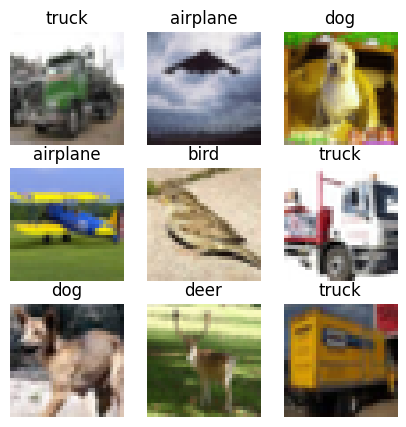

In [125]:
# show train image and label
train_iter = iter(train_dl)
first_batch = next(train_iter)
images = first_batch[0]
labels = first_batch[1]

print(images.shape)
print(labels.shape)

fig = plt.figure(figsize=(5,5))
rows, cols = (3,3)
for i in range(1, rows*cols+1):
    image = images[i-1]
    label = LABELS[labels[i-1].item()]
    fig.add_subplot(rows, cols, i)
    plt.axis('off')
    plt.title(label)
    image = np.transpose(image.numpy(), (1,2,0))
    plt.imshow(image)

plt.show()

In [126]:
layer_cfg = {
    'VGG11': [64, 'MP', 128, 'MP', 256, 256, 'MP', 512, 512, 'MP', 512, 512, 'MP'],
    'VGG13': [64, 64, 'MP', 128, 128, 'MP', 256, 256, 'MP', 512, 512, 'MP', 512, 512, 'MP'],
    'VGG16': [64, 64, 'MP', 128, 128, 'MP', 256, 256, 256, 'MP', 512, 512, 512, 'MP', 512, 512, 512, 'MP'],
    'VGG19': [64, 64, 'MP', 128, 128, 'MP', 256, 256, 256, 256, 'MP', 512, 512, 512, 512, 'MP', 512, 512, 512, 512, 'MP'],

}
class VGGNet(nn.Module):
    def __init__(self, cfg) -> None:
        super().__init__()
        self.conv_layers = self.make_conv_layer(cfg)
        self.classifier_layers = self.make_classifier()
    

    def forward(self, x):
        out = self.conv_layers(x)
        out = out.view(out.size(0), -1)
        out = self.classifier_layers(out)
        return out

    def make_conv_layer(self, cfg):
        layers = []
        in_channels = 3
        for layer in layer_cfg[cfg]:
            if layer == 'MP':
                layers += [nn.MaxPool2d(2, 2)]
            else:
                layers += [
                    nn.Conv2d(in_channels=in_channels, out_channels=layer, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(layer),
                    nn.ReLU()
                ]

                in_channels = layer
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    
    def make_classifier(self):
        #return nn.Linear(in_features=512, out_features=10)
        return nn.Sequential(
            nn.Linear(512,4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=10),
        )


In [127]:
model = VGGNet('VGG11').to(DEVICE)
summary(model, (BATCH_SIZE, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
VGGNet                                   [256, 10]                 --
├─Sequential: 1-1                        [256, 512, 1, 1]          --
│    └─Conv2d: 2-1                       [256, 64, 32, 32]         1,792
│    └─BatchNorm2d: 2-2                  [256, 64, 32, 32]         128
│    └─ReLU: 2-3                         [256, 64, 32, 32]         --
│    └─MaxPool2d: 2-4                    [256, 64, 16, 16]         --
│    └─Conv2d: 2-5                       [256, 128, 16, 16]        73,856
│    └─BatchNorm2d: 2-6                  [256, 128, 16, 16]        256
│    └─ReLU: 2-7                         [256, 128, 16, 16]        --
│    └─MaxPool2d: 2-8                    [256, 128, 8, 8]          --
│    └─Conv2d: 2-9                       [256, 256, 8, 8]          295,168
│    └─BatchNorm2d: 2-10                 [256, 256, 8, 8]          512
│    └─ReLU: 2-11                        [256, 256, 8, 8]          --


In [128]:
optimizer = torch.optim.SGD(params=model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss().cuda()

In [129]:
def train(model, train_dl, device, optimizer, criterion):
    model.train()
    loss_sum = 0

    for batch_ix, (data, target) in enumerate(train_dl):
        data, target = (data.to(device), target.to(device))
        optimizer.zero_grad()
        
        # calculate prediction
        output = model(data)

        # calcuate loss
        loss = criterion(output, target)
        loss_sum += loss.item()

        # back propagation
        loss.backward()

        # update weight
        optimizer.step()
        
    loss_avg = loss_sum / len(train_dl)
    
    return loss_avg


In [130]:
def val(model, val_dl, device, criterion):
    model.eval()
    loss_sum = 0
    correct = 0

    with torch.no_grad():
        for batch_ix, (data, target) in enumerate(val_dl):
            data, target = (data.to(device), target.to(device))

            # calculate prediction
            output = model(data)

            # calculate loss
            loss = criterion(output, target)
            loss_sum += loss.item()

            predict = output.max(1, keepdim=True)[1]
            correct += predict.eq(target.view_as(predict)).sum().item()

    loss_avg = loss_sum / len(val_dl)
    accuarcy = 100. * correct / len(val_dl.dataset)

    return loss_avg, accuarcy

In [131]:
train_losses = []
val_losses = []

for epoch in range(0, EPOCHS):
    train_loss = train(model, train_dl, DEVICE, optimizer, criterion)
    val_loss, val_accuracy = val(model, val_dl, DEVICE, criterion)

    train_losses += [train_loss]
    val_losses += [val_loss]

    print('EPOCH[{:02d}] train:{:.4f}, val:{:.4f}, val_accuracy:{:.3f}%'.format(epoch+1, train_loss, val_loss, val_accuracy))

EPOCH[01] train:1.3626, val:1.6396, val_accuracy:46.310%
EPOCH[02] train:0.8375, val:0.8959, val_accuracy:68.750%
EPOCH[03] train:0.6314, val:0.7787, val_accuracy:73.280%
EPOCH[04] train:0.4936, val:0.8029, val_accuracy:74.160%
EPOCH[05] train:0.3860, val:0.8988, val_accuracy:72.070%
EPOCH[06] train:0.2976, val:0.7226, val_accuracy:77.360%
EPOCH[07] train:0.2269, val:0.9338, val_accuracy:72.730%
EPOCH[08] train:0.1825, val:0.9656, val_accuracy:74.990%
EPOCH[09] train:0.1474, val:0.8271, val_accuracy:77.360%
EPOCH[10] train:0.1071, val:0.8473, val_accuracy:78.860%
EPOCH[11] train:0.0945, val:0.8586, val_accuracy:79.300%
EPOCH[12] train:0.0797, val:0.9445, val_accuracy:78.150%
EPOCH[13] train:0.0683, val:1.2335, val_accuracy:72.900%
EPOCH[14] train:0.0606, val:1.0031, val_accuracy:78.700%
EPOCH[15] train:0.0504, val:1.0165, val_accuracy:79.110%
EPOCH[16] train:0.0528, val:1.0427, val_accuracy:77.690%
EPOCH[17] train:0.0321, val:0.9708, val_accuracy:80.020%
EPOCH[18] train:0.0382, val:0.9

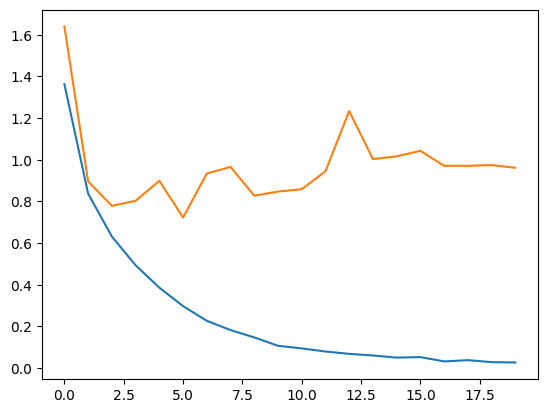

In [133]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

[3 8 8 8 6]
[3 8 8 0 6]
(256, 3, 32, 32)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


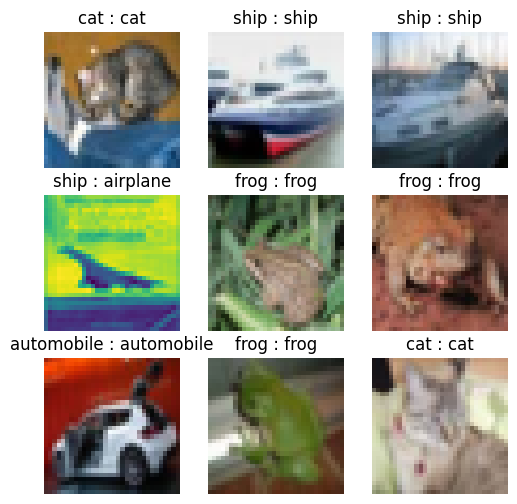

In [161]:
val_iter = iter(val_dl)
first_batch = next(val_iter)
images = first_batch[0]
labels = first_batch[1].numpy()
output = model(images.to(DEVICE))
predict = output.max(1, keepdim=True)[1].view(-1).cpu().numpy()
print(predict[:5])
print(labels[:5])
images = images.numpy()
print(images.shape)

rows, cols = 3, 3
fig = plt.figure(figsize=(6,6))
for i in range(1, rows*cols +1):
    image = np.transpose(images[i-1], (1,2,0))

    plt.subplot(rows, cols, i)
    plt.axis('off')
    pred_label = LABELS[predict[i-1]]
    target_label = LABELS[labels[i-1]]
    plt.title('{} : {}'.format(pred_label, target_label))
    if pred_label == target_label:
        plt.imshow(image)
    else:
        plt.imshow(image[:,:,:1])



